# Load Packages

In [1]:
# Main modules 
import torch
from torch import Generator
from torch.utils.data import DataLoader, random_split
import torchvision
from torchvision.datasets import ImageFolder
from torchvision.transforms.functional import to_pil_image
import pandas as pd
import matplotlib.pyplot as plt

# Custom modules
from frogfunctions import Model 
from frogfunctions import setup_seed, train_loop, test_loop, train_model, plot_probabilities

In [2]:
# Dataframe output format
pd.set_option('display.float_format', lambda x: '%.6f' % x)

# Set device 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

# Set random seed for reproduction

In [3]:
SEED = 42
setup_seed(SEED)

# Import data

In [4]:
data_dir = "../data/"

In [5]:
# Download and load the training data
dataset_all = ImageFolder(data_dir, transform=torchvision.transforms.ToTensor())

# Print number in full data set
size_all = len(dataset_all)
print(f'Before splitting the full dataset into train and test: len(dataset_all) = {size_all}')

# Split into Test, Validation, and Training
size_test = int(size_all * 0.10)
size_val = int(size_all * 0.10)
size_train = size_all - size_test - size_val
dataset_test, dataset_val, dataset_train = random_split(dataset_all, [size_test, size_val, size_train], 
                                                        generator=Generator().manual_seed(SEED))

print(f'After splitting the full dataset into test, validation, and training: \n \
      len(dataset_test) = {len(dataset_test)} \n \
      len(dataset_val) = {len(dataset_val)} \n \
      len(dataset_train) = {len(dataset_train)}')

Before splitting the full dataset into train and test: len(dataset_all) = 700
After splitting the full dataset into test, validation, and training: 
       len(dataset_test) = 70 
       len(dataset_val) = 70 
       len(dataset_train) = 560


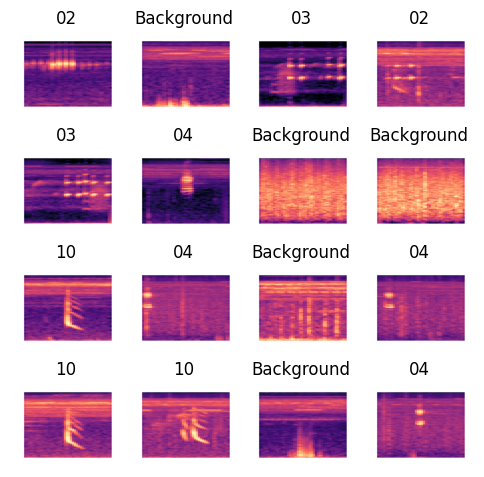

In [6]:
# Visualize some of the train samples of one batch
# Make sure you create the class names that match the order of their appearances in the "files" variable
class_names = ['02', '03', '04', '05', '08', '10', 'Background']

# Rows and columns are set to fit one training batch (16)
n_rows = 4
n_cols = 4
plt.figure(figsize=(n_cols * 1.5, n_rows * 1.5))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        image, target = dataset_train[index]
        plt.imshow(to_pil_image(image))
        plt.axis('off')
        plt.title(class_names[target], fontsize=12)
plt.subplots_adjust(wspace=.05, hspace=.05)
plt.show()

# Prepare data

In [7]:
# Define batch size
batch_size = 16

In [8]:
# Load data into DataLoader
train_dataloader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(dataset_val, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(dataset_test, batch_size=batch_size, shuffle=True)

dataloaders = {'train':train_dataloader, 'val':val_dataloader}
dataset_sizes = {'train':len(dataset_train), 'val':len(dataset_val)}

# Define parameters for model

In [9]:
# Define number of classes
num_classes = 7

In [10]:
# Create model 
model = Model(num_classes=num_classes).to(device)

In [11]:
# Define hyperparameters
learning_rate = 0.002
weight_decay = 0.005
momentum=0.09

# Define loss function
loss_fn = torch.nn.CrossEntropyLoss()

# Define optimizer 
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=weight_decay, momentum=momentum)

# Train model

Epoch 1
-------------------------------
loss: 1.936872  [   16/  560]
Training Error: Accuracy: 25.7%
Validation Error: Accuracy: 8.6%, Avg loss: 1.935157 

Epoch 2
-------------------------------
loss: 1.905843  [   16/  560]
Training Error: Accuracy: 35.9%
Validation Error: Accuracy: 62.9%, Avg loss: 1.837350 

Epoch 3
-------------------------------
loss: 1.825194  [   16/  560]
Training Error: Accuracy: 57.7%
Validation Error: Accuracy: 64.3%, Avg loss: 1.730802 

Epoch 4
-------------------------------
loss: 1.803874  [   16/  560]
Training Error: Accuracy: 58.6%
Validation Error: Accuracy: 77.1%, Avg loss: 1.576923 

Epoch 5
-------------------------------
loss: 1.605634  [   16/  560]
Training Error: Accuracy: 70.2%
Validation Error: Accuracy: 71.4%, Avg loss: 1.408819 

Epoch 6
-------------------------------
loss: 1.409799  [   16/  560]
Training Error: Accuracy: 73.8%
Validation Error: Accuracy: 78.6%, Avg loss: 1.197076 

Epoch 7
-------------------------------
loss: 1.20483

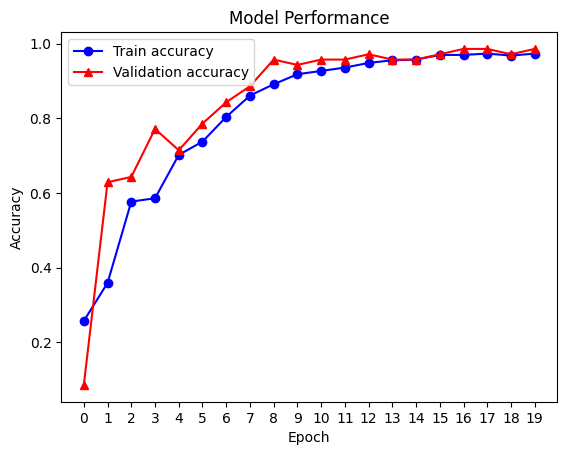

In [12]:
# Set number of epochs 
epochs = 20

# Train
train_model(train_dataloader, val_dataloader, model, loss_fn, optimizer, epochs)

# Save model

In [13]:
# Save model 
torch.save(model.state_dict(), '../saved_models/model')

# Load model

In [14]:
PATH = '../saved_models/model'
model = Model(num_classes=7).to(device)
model.load_state_dict(torch.load(PATH))
model.eval();

In [15]:
# Test accuracy
test_loop(test_dataloader, model, loss_fn, epoch = 1, method='test')

Test Error: Accuracy: 98.6%, Avg loss: 0.082162 



In [16]:
# Class prediction probabilities
predictions = test_loop(test_dataloader, model, loss_fn, epoch=1, method='prob')
predictions.head()

,Upper Amazon tree frog,Demerara Falls tree frog,Chirping Robber frog,Vanzolini's Amazon frog,South American common toad,Peters' dwarf frog,Background
0,0.167527,0.000900,0.004184,0.281791,0.001831,0.012204,0.531562
1,0.006971,0.002064,0.989248,0.001207,0.000133,0.000205,0.000172
2,0.062081,0.002608,0.001185,0.922779,0.000177,0.000314,0.010855
3,0.003014,0.000396,0.995147,0.000307,0.000241,0.000278,0.000616
4,0.022700,0.009545,0.000528,0.965961,0.000060,0.000086,0.001120


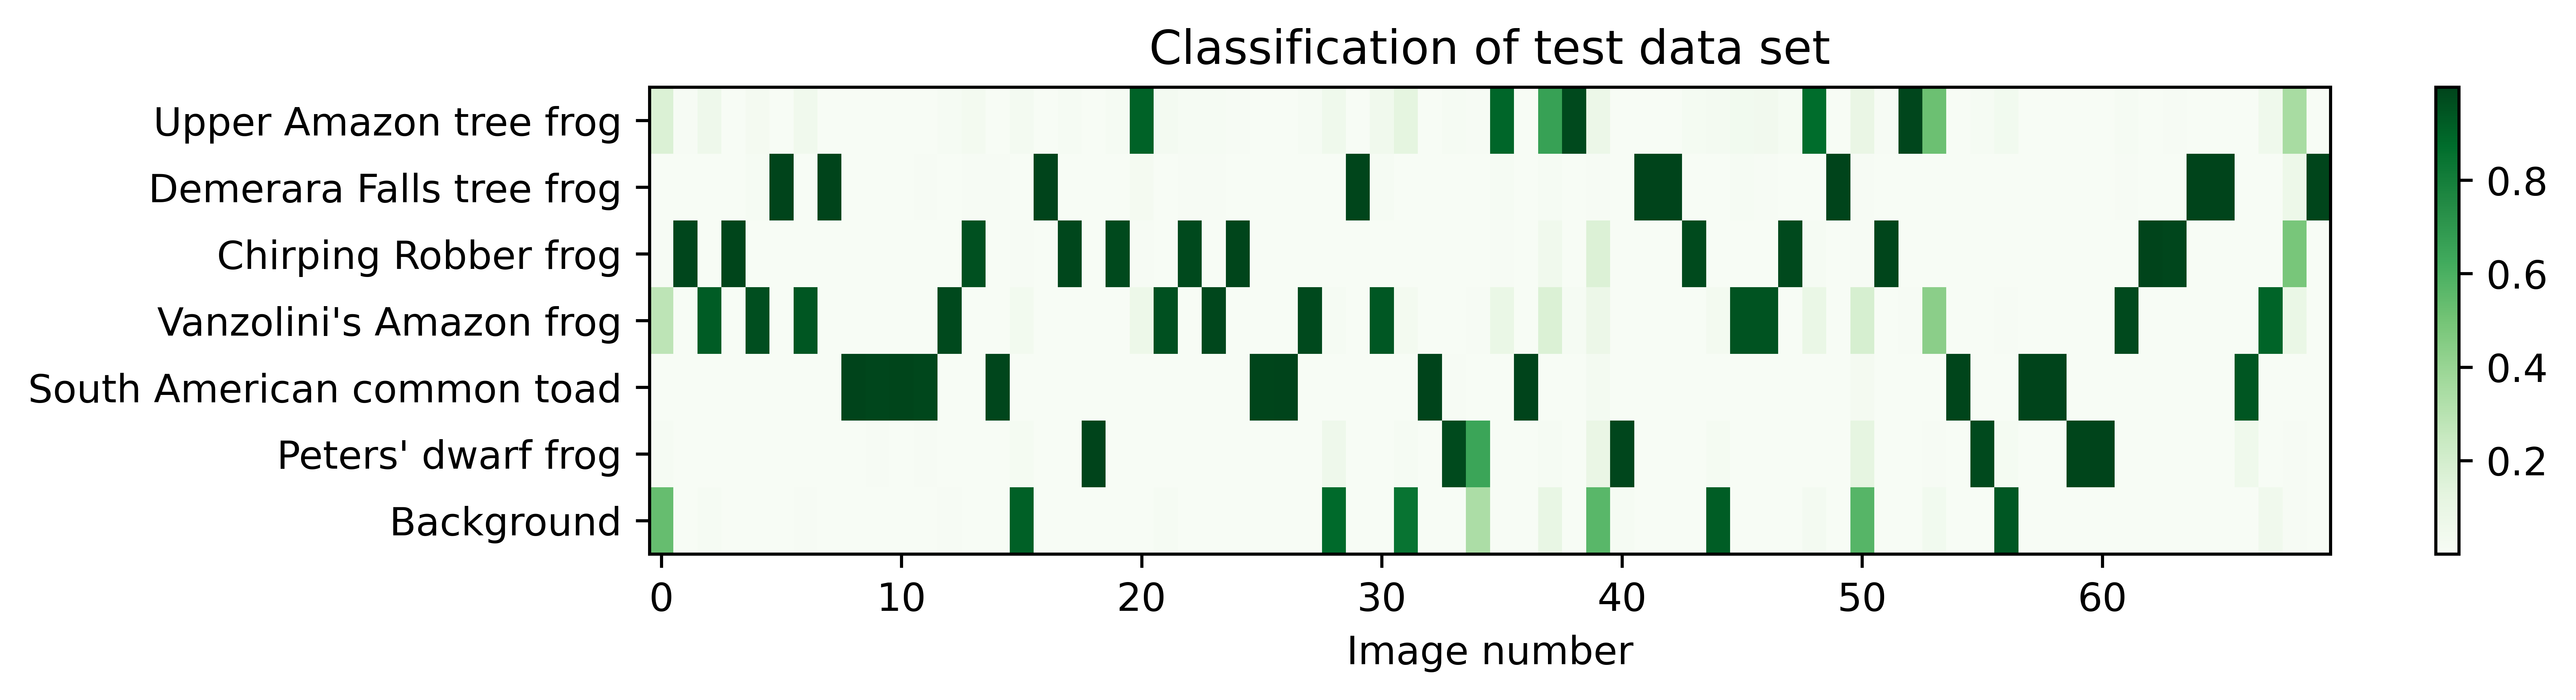

In [17]:
# Plot probabilities
plot_probabilities(predictions, title='Classification of test data set', xlabel='Image number')

----

# Test model on long audio files (Ex. 1)

In [18]:
test1_dir = "../test_data/city/"

In [19]:
# Download and load the training data
test1 = ImageFolder(test1_dir, transform=torchvision.transforms.ToTensor())

# Load data into DataLoader
test1_dataloader = DataLoader(test1, batch_size=batch_size, shuffle=False)

# Class prediction probabilities
test1_predictions = test_loop(test1_dataloader, model, loss_fn, epoch=1, method='prob')
test1_predictions.head()

,Upper Amazon tree frog,Demerara Falls tree frog,Chirping Robber frog,Vanzolini's Amazon frog,South American common toad,Peters' dwarf frog,Background
0,0.046832,0.001603,0.101286,0.019145,0.024755,0.019691,0.786689
1,0.026121,0.001261,0.036099,0.008381,0.050715,0.023461,0.853962
2,0.022946,0.001727,0.051890,0.008296,0.070396,0.032760,0.811985
3,0.088701,0.002226,0.108437,0.051610,0.013843,0.018511,0.716672
4,0.401787,0.000490,0.004019,0.381567,0.000185,0.001453,0.210500


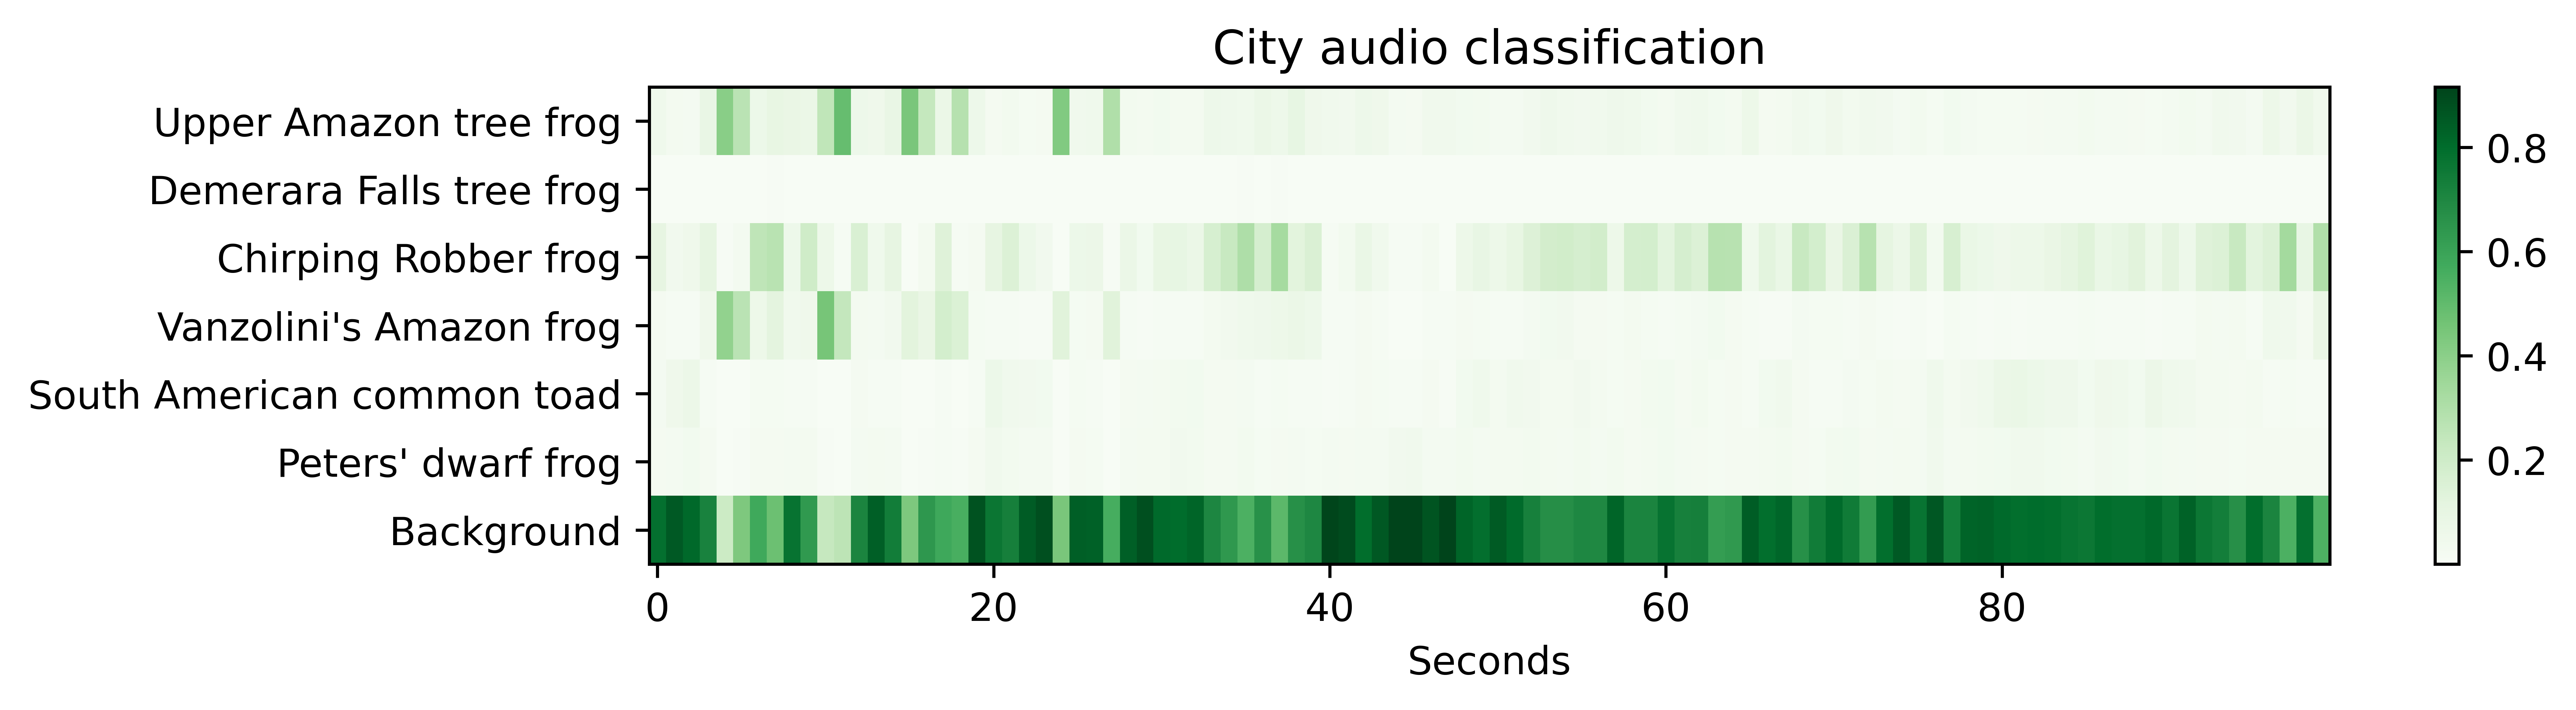

In [20]:
# Plot probabilities
plot_probabilities(test1_predictions, title='City audio classification', xlabel='Seconds')

# Test model on long audio files (Ex. 2)

In [21]:
test2_dir = "../test_data/long/"

In [22]:
# Download and load the training data
test2 = ImageFolder(test2_dir, transform=torchvision.transforms.ToTensor())

# Load data into DataLoader
test2_dataloader = DataLoader(test2, batch_size=batch_size, shuffle=False)

# Class prediction probabilities
test2_predictions = test_loop(test2_dataloader, model, loss_fn, epoch=1, method='prob')
test2_predictions.head()

,Upper Amazon tree frog,Demerara Falls tree frog,Chirping Robber frog,Vanzolini's Amazon frog,South American common toad,Peters' dwarf frog,Background
0,0.638507,0.002292,0.004922,0.142371,0.001136,0.009960,0.200812
1,0.577367,0.001359,0.003034,0.124169,0.000861,0.012774,0.280435
2,0.831685,0.010776,0.057997,0.067545,0.002174,0.007279,0.022545
3,0.831198,0.006655,0.033706,0.072426,0.001949,0.007290,0.046776
4,0.857055,0.006727,0.045032,0.042422,0.001861,0.006760,0.040145


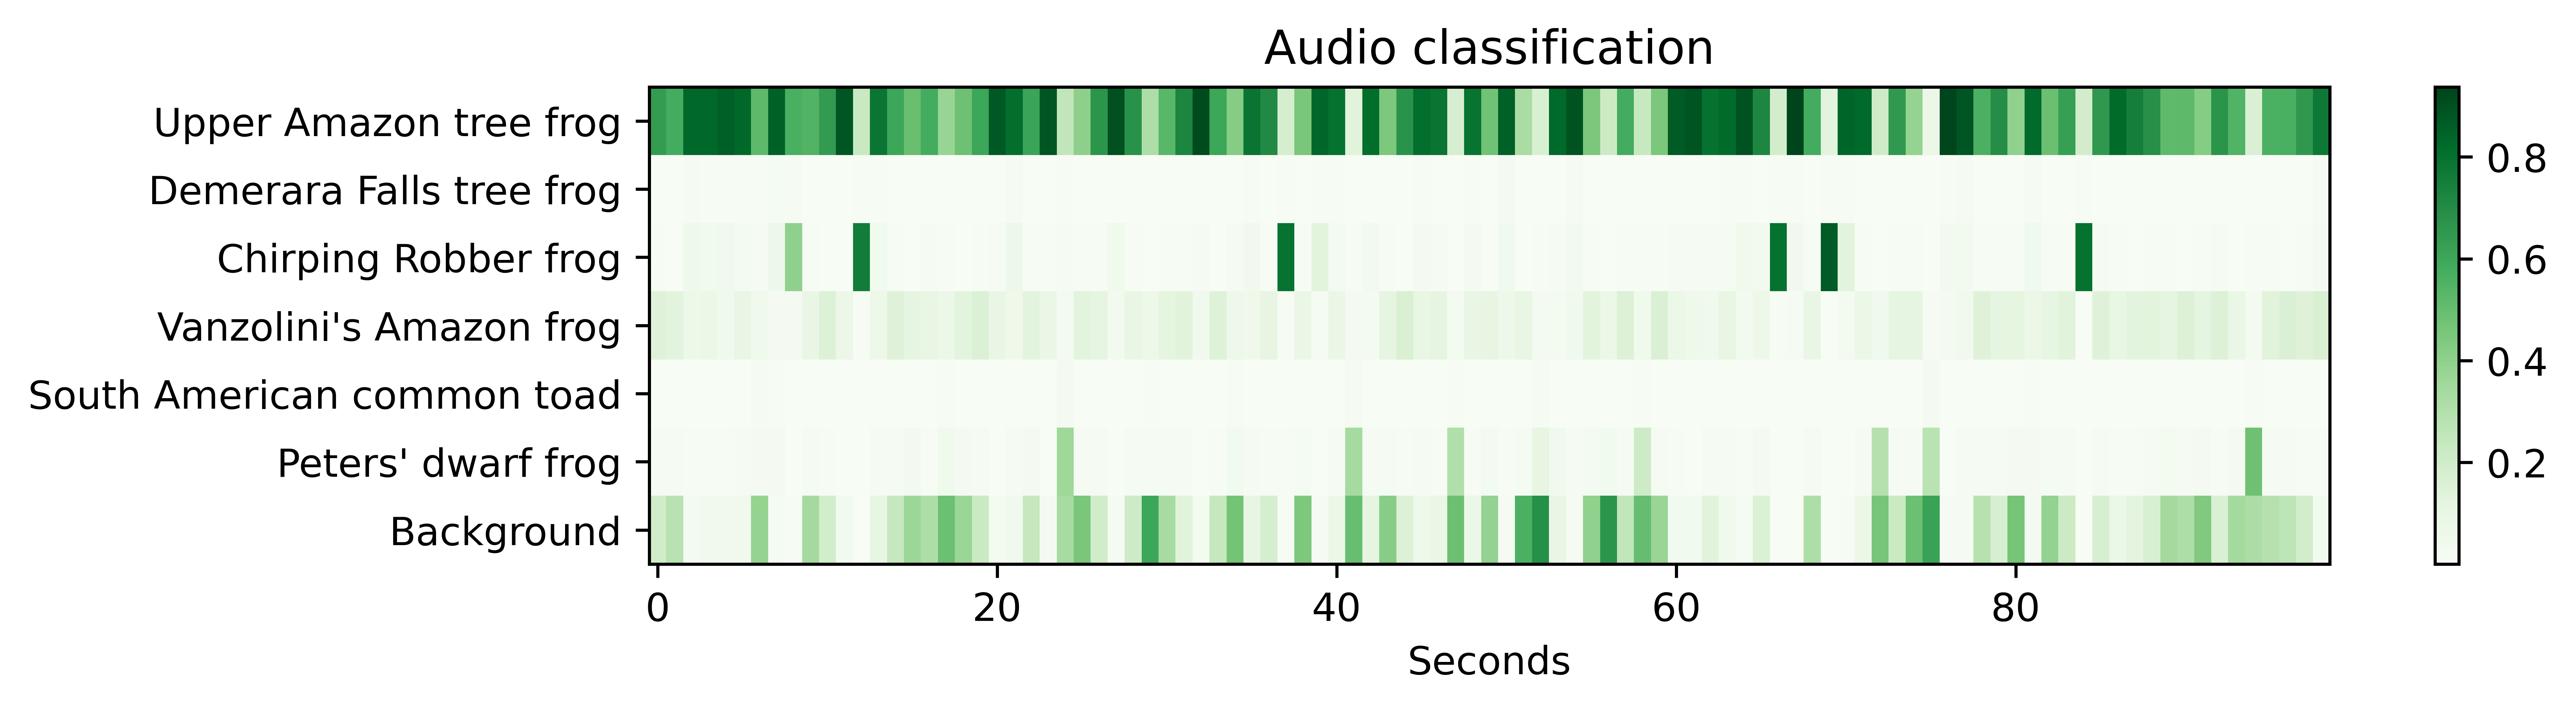

In [23]:
# Plot probabilities
plot_probabilities(test2_predictions, title='Audio classification', xlabel='Seconds')